In [62]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})
from pathlib import Path
from itertools import count
from PIL import Image
import torch
CODE_SIZE = 25

IMG_SHAPE = (3, 64, 176)

In [63]:
import torch, torch.nn as nn
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    device = torch.device('cuda')
    print("Using GPU")
else:
    device = torch.device('cpu')
    print("Not using GPU")
    
from torch.utils.data import Dataset

Torch version: 1.0.1.post2
Using GPU


In [64]:
class GlassesDataset(Dataset):
    def __init__(self, path, transform=None):
        self.data = []
        self.transform = transform
        for img_path in Path(path).iterdir():
            if img_path.suffix[1:].lower() not in ('jpg', 'png'):
                continue
                
            # this crop was chosen because glasses dimension mentioned in the paper was 64x176
            img = np.array(Image.open(str(img_path)))[52:116, 23:199, :]
            
            if self.transform is not None:
                img = self.transform(img)
            
            self.data.append(img)
        self.data = (np.array(self.data).transpose(0, 3, 1, 2) - 128.) / 128.
        
    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

            

In [65]:
train_dataset = GlassesDataset('eyeglasses')

In [66]:
def sample_noise_batch(batch_size):
    noise = torch.randn(batch_size, CODE_SIZE)
    return noise.cuda() if use_cuda else noise.cpu()
    
class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape=shape
    def forward(self,input):
        return input.view(self.shape)

In [67]:
class GlassesGenerator(nn.Module):
    

        
    def __init__(self,):
        super(GlassesGenerator, self).__init__()
        self.ix = ('layer_%i'%i for i in count())
        self.layers = nn.Sequential()
        self.layers.add_module(next(self.ix), nn.Linear(CODE_SIZE, 7040))
        self.layers.add_module(next(self.ix), nn.BatchNorm1d(7040))
        self.layers.add_module(next(self.ix), nn.ReLU())
        self.layers.add_module(next(self.ix), Reshape([-1, 160, 4, 11]))
        
        self.add_deconv_block(160, 80)
        self.add_deconv_block(80, 40)
        self.add_deconv_block(40, 20)
        
        self.layers.add_module(next(self.ix), nn.ConvTranspose2d(20, 3, 5, stride=2, padding=2, output_padding=1))
        self.layers.add_module(next(self.ix), nn.Tanh())
    
    def add_deconv_block(self, in_channels, out_channels):
        self.layers.add_module(next(self.ix), nn.ConvTranspose2d(in_channels,
                                                                 out_channels,
                                                                 5,
                                                                 stride=2,
                                                                 padding=2,
                                                                 output_padding=1))
        self.layers.add_module(next(self.ix), nn.BatchNorm2d(out_channels))
        self.layers.add_module(next(self.ix), nn.ReLU())
            
        
    def forward(self, x):
        return self.layers(x)

In [68]:
class GlassesDiscriminator(nn.Module):
    

        
    def __init__(self,):
        super(GlassesDiscriminator, self).__init__()
        self.layers = nn.Sequential(nn.Conv2d(3, 20, 5, stride=2, padding=2),
#                               nn.AvgPool2d(2),
                              nn.LeakyReLU(),
                              
                              nn.Conv2d(20, 40, 5, stride=2, padding=2), 
#                               nn.AvgPool2d(2),
                              nn.BatchNorm2d(40), 
                              nn.LeakyReLU(),
                              
                              nn.Conv2d(40, 80, 5, stride=2, padding=2), 
#                               nn.AvgPool2d(2),
                              nn.BatchNorm2d(80),
                              nn.LeakyReLU(),
                              
                              nn.Conv2d(80, 160, 5, stride=2, padding=2), 
#                               nn.AvgPool2d(2),
                              nn.BatchNorm2d(160),
                              nn.LeakyReLU(),
                              Reshape([-1, 7040]),
                              
                              nn.Linear(7040, 1),
#                               nn.Sigmoid()
                             )
    
            
        
    def forward(self, x):
        return self.layers(x)

In [74]:
discriminator_net = GlassesDiscriminator()
discriminator_net.load_state_dict(torch.load('discriminator_model.pth'))
discriminator_net.to(device);

In [75]:
generator_net = GlassesGenerator()
generator_net.load_state_dict(torch.load('generator_model.pth'))
generator_net.to(device);

In [76]:
def sample_data_batch(batch_size):
    idxs = np.random.choice(np.arange(len(train_dataset)), size=batch_size)
    batch = torch.tensor(train_dataset[idxs], dtype=torch.float32)
    return batch.cuda() if use_cuda else batch.cpu()

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

In [77]:
def generator_loss(noise, discriminator, generator):
    """
    1. generate data given noise
    2. compute log P(real | gen noise)
    3. return generator loss (should be scalar)
    """
    generated_data = generator(noise) #sample_data_batch(5) #<generate data given noise>
    
    disc_on_generated_data =  discriminator(generated_data)# <discriminator's opinion on generated data>
    
    logp_gen_is_real = F.logsigmoid(1 - disc_on_generated_data)
    
    loss = torch.mean(logp_gen_is_real).view(1) #<generator loss. Mind the sign!>
    
    return loss

def discriminator_loss(real_data, generated_data, discriminator):
    """
    1. compute discriminator's output on real & generated data
    2. compute log-probabilities of real data being real, generated data being fake
    3. return discriminator loss (scalar)
    """
    disc_on_real_data = discriminator(real_data) #<discriminator's prediction on real data>
    disc_on_fake_data = discriminator(generated_data) #<discriminator's prediction on generated data>
    
    logp_real_is_real = F.logsigmoid(disc_on_real_data)
    logp_gen_is_fake = F.logsigmoid(- disc_on_fake_data)
    
    loss = (-logp_real_is_real.mean() - logp_gen_is_fake.mean()).view(1) # <discriminator loss>
    return loss

In [80]:
loss = generator_loss(sample_noise_batch(32), discriminator=discriminator_net, generator=generator_net)

print(loss)

assert len(loss.shape) == 1 and loss.shape[0] == 1, "loss must be scalar"

loss = discriminator_loss(sample_data_batch(32), 
                   generator(sample_noise_batch(32)), discriminator=discriminator_net)

print(loss)

assert len(loss.shape) == 1 and loss.shape[0] == 1, "loss must be scalar"


tensor([-3.0080e-05], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.0001], device='cuda:0', grad_fn=<ViewBackward>)


In [81]:
def sample_images(nrow, ncol, generator, sharp=False):
    images = generator(sample_noise_batch(batch_size=nrow*ncol))
    images = images.data.cpu().numpy().transpose([0, 2, 3, 1])
    if np.var(images)!=0:
        images = images.clip(np.min(train_dataset.data),np.max(train_dataset.data))
        images = (images * 128 + 128).astype(int)
        print(images.min(), images.max())
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i], cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i], cmap="gray")
    plt.show()

def sample_probas(batch_size):
    plt.title('Generated vs real data')
    D_real = F.sigmoid(discriminator(sample_data_batch(batch_size)))
    generated_data_batch = generator(sample_noise_batch(batch_size))
    D_fake = F.sigmoid(discriminator(generated_data_batch))
    
    plt.hist(D_real.data.cpu().numpy(),
             label='D(x)', alpha=0.5, range=[0,1])
    plt.hist(D_fake.data.cpu().numpy(),
             label='D(G(z))', alpha=0.5, range=[0,1])
    plt.legend(loc='best')
    plt.show()

0 255


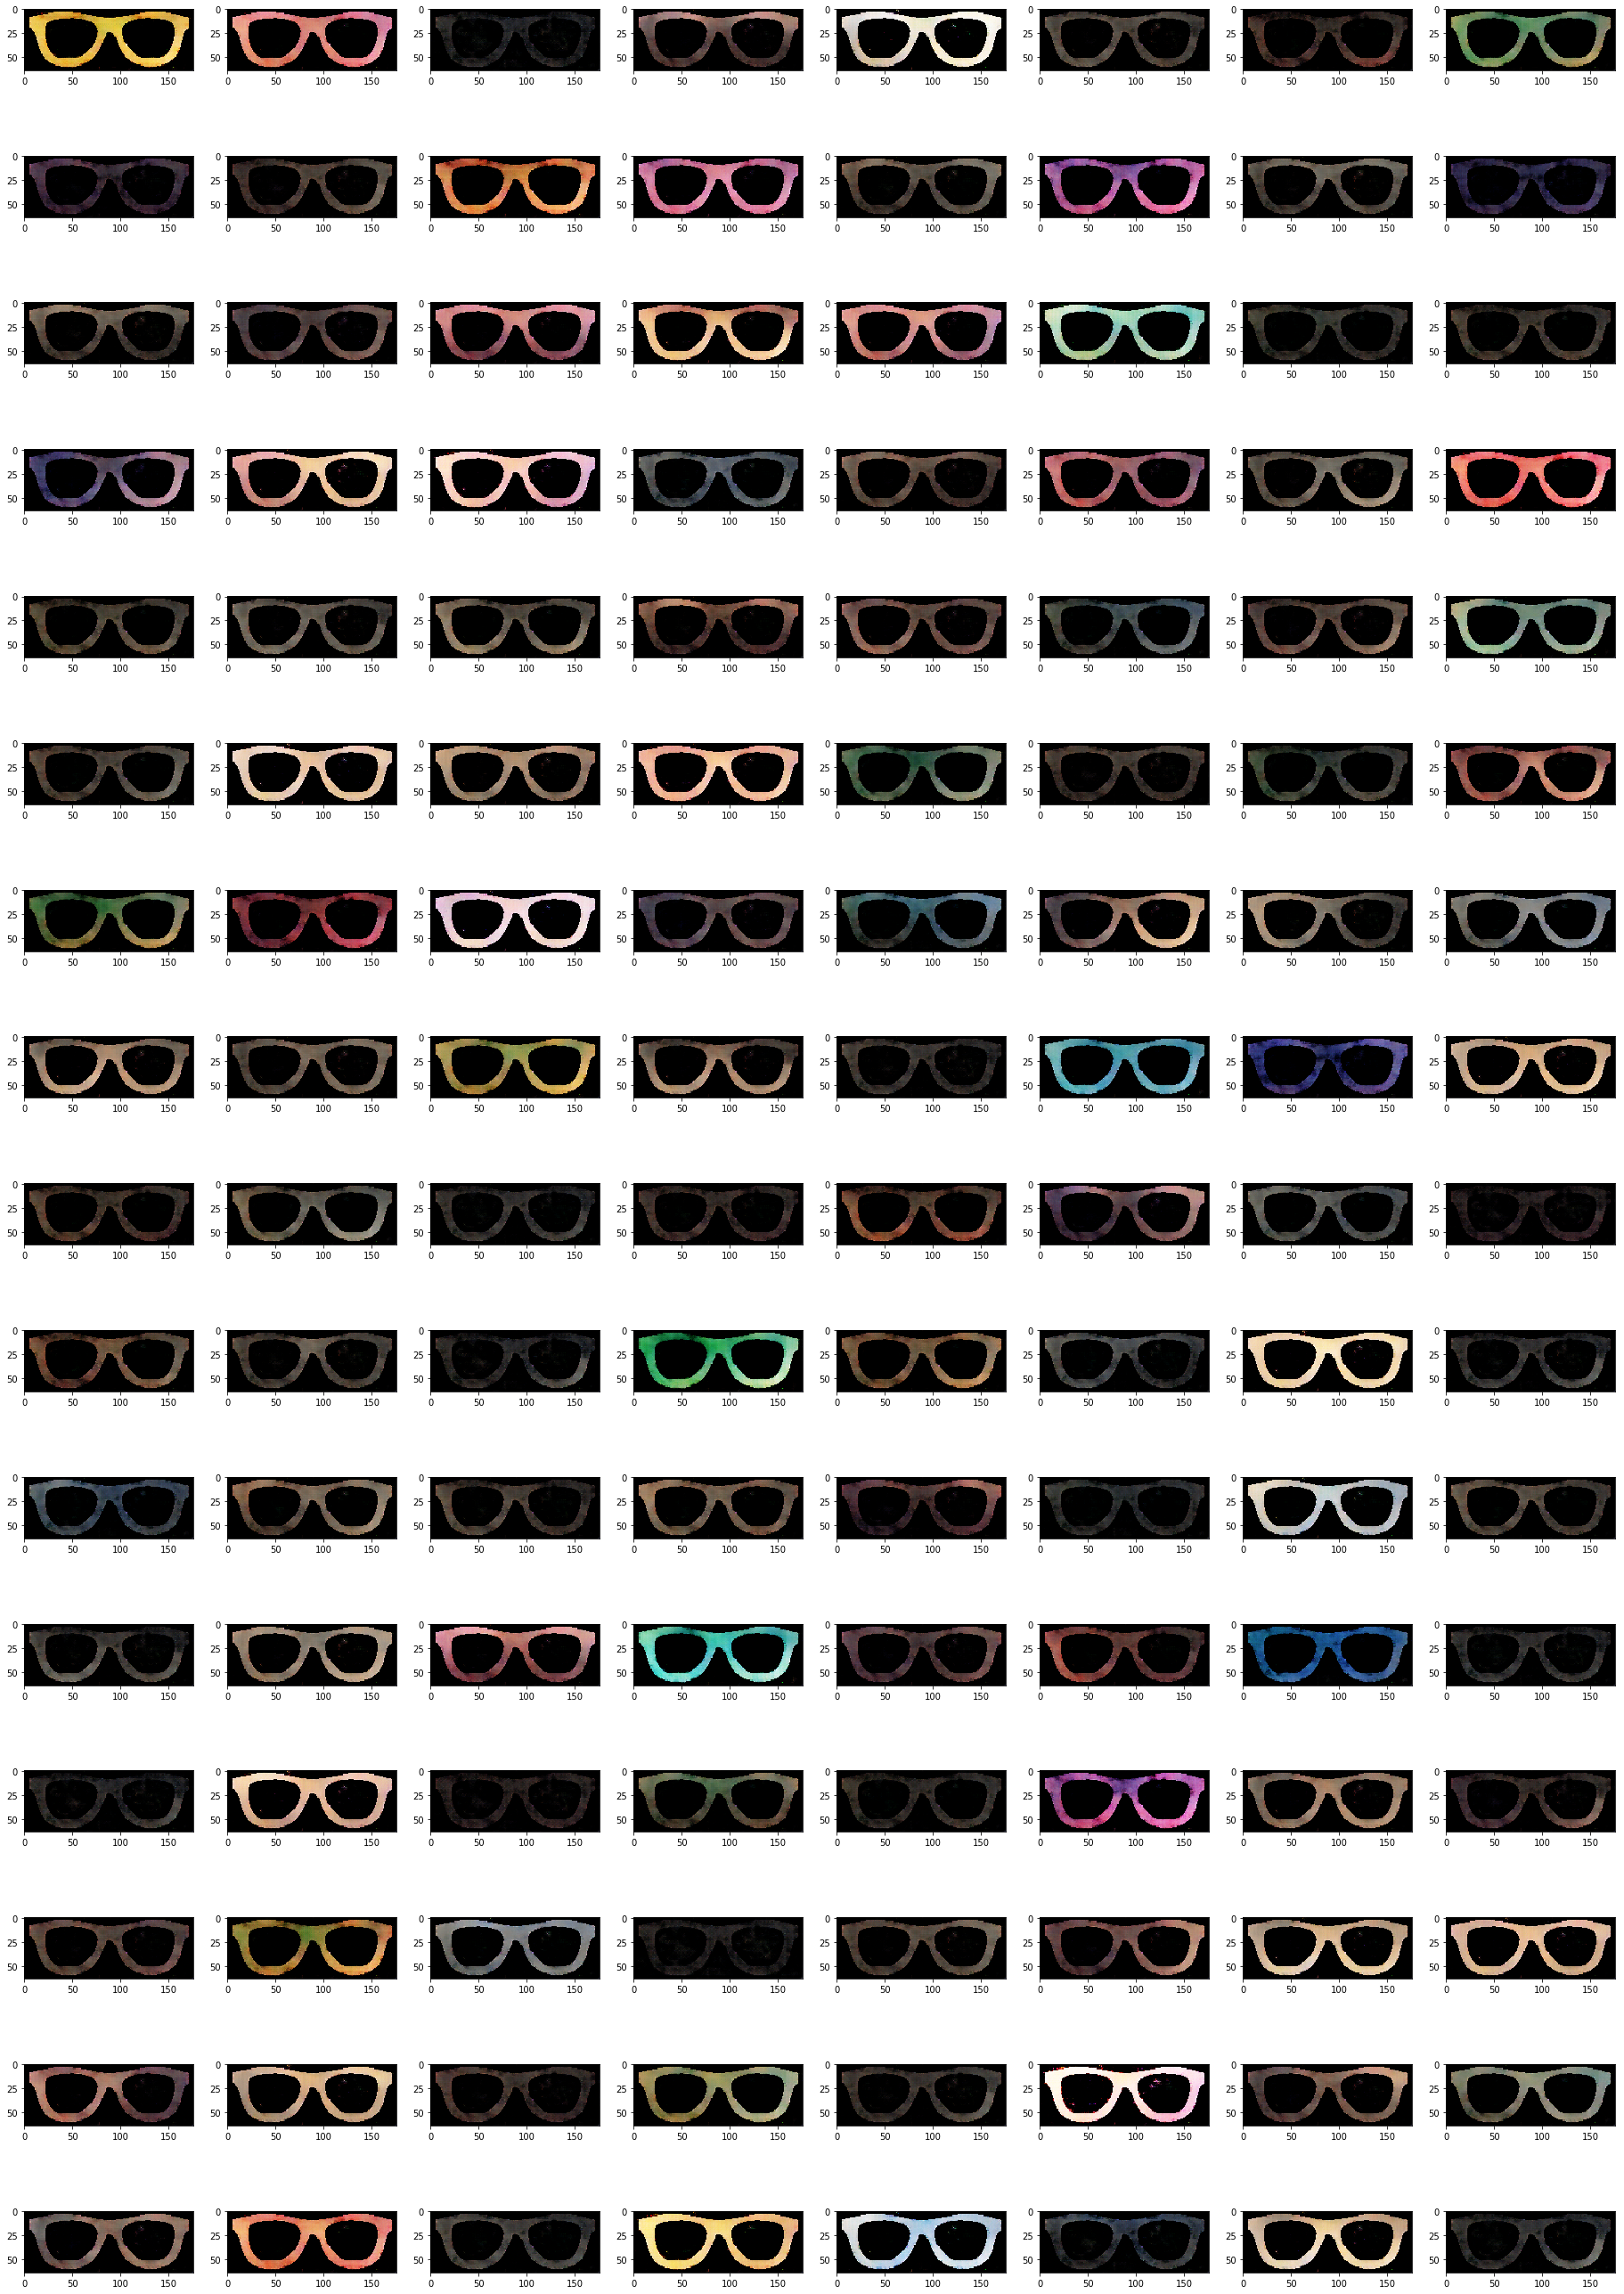

In [83]:
plt.figure(figsize=[32, 48])
sample_images(16, 8, generator_net)

## Training

In [84]:
discriminator = discriminator_net
generator = generator_net

In [85]:
#optimizers
disc_opt = torch.optim.SGD(discriminator.parameters(), lr=2e-4)
gen_opt = torch.optim.Adam(generator.parameters(), lr=2e-4)

0 253


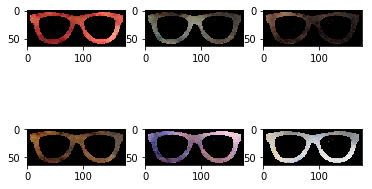

/home/tva/.local/lib/python3.5/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


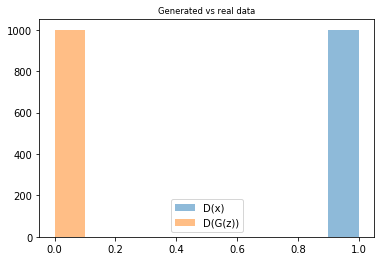

d loss 0.0013792980462312698
d loss 0.0037214080803096294
d loss 0.00115815713070333
d loss 0.0010523227974772453
d loss 0.0013924482045695186
g loss -0.00025672116316854954
d loss 0.00374242989346385
d loss 0.0025182871613651514
d loss 0.0029880215879529715
d loss 0.001690006465651095
d loss 0.0009870370849967003
g loss -0.0008139816345646977
d loss 0.0030028705950826406
d loss 0.006515440996736288
d loss 0.00392402708530426
d loss 0.001490902155637741
d loss 0.0040743788704276085
g loss -0.0012616124004125595
d loss 0.016406934708356857
d loss 0.006699938792735338
d loss 0.0025400337763130665
d loss 0.005061710253357887
d loss 0.002355090342462063
g loss -0.0019633034244179726



KeyboardInterrupt: 

In [87]:
from IPython import display
from tqdm import tnrange
batch_size = 100

for epoch in tnrange(50000):
    
    # Train discriminator
    for i in range(5):
        real_data = sample_data_batch(batch_size)
        fake_data = generator(sample_noise_batch(batch_size))
        loss = discriminator_loss(real_data, fake_data, discriminator=discriminator)
        print('d loss', loss.item())
        disc_opt.zero_grad()
        loss.backward()
        disc_opt.step()
        
    # Train generator
    for i in range(1):
        noise = sample_noise_batch(batch_size)
        loss = generator_loss(noise, discriminator=discriminator, generator=generator)
        print('g loss', loss.item())
        gen_opt.zero_grad()
        loss.backward()
        gen_opt.step()

    if epoch %100==0:
        display.clear_output(wait=True)
        sample_images(2, 3, generator, True)
        sample_probas(1000)
        

In [99]:
from datetime import datetime
mrk = datetime.now().strftime('%d_%h__%H_%M')
torch.save(generator.state_dict(), 'generator_' + mrk + '.pth')
torch.save(discriminator.state_dict(), 'discriminator' + mrk + '.pth')

0 255


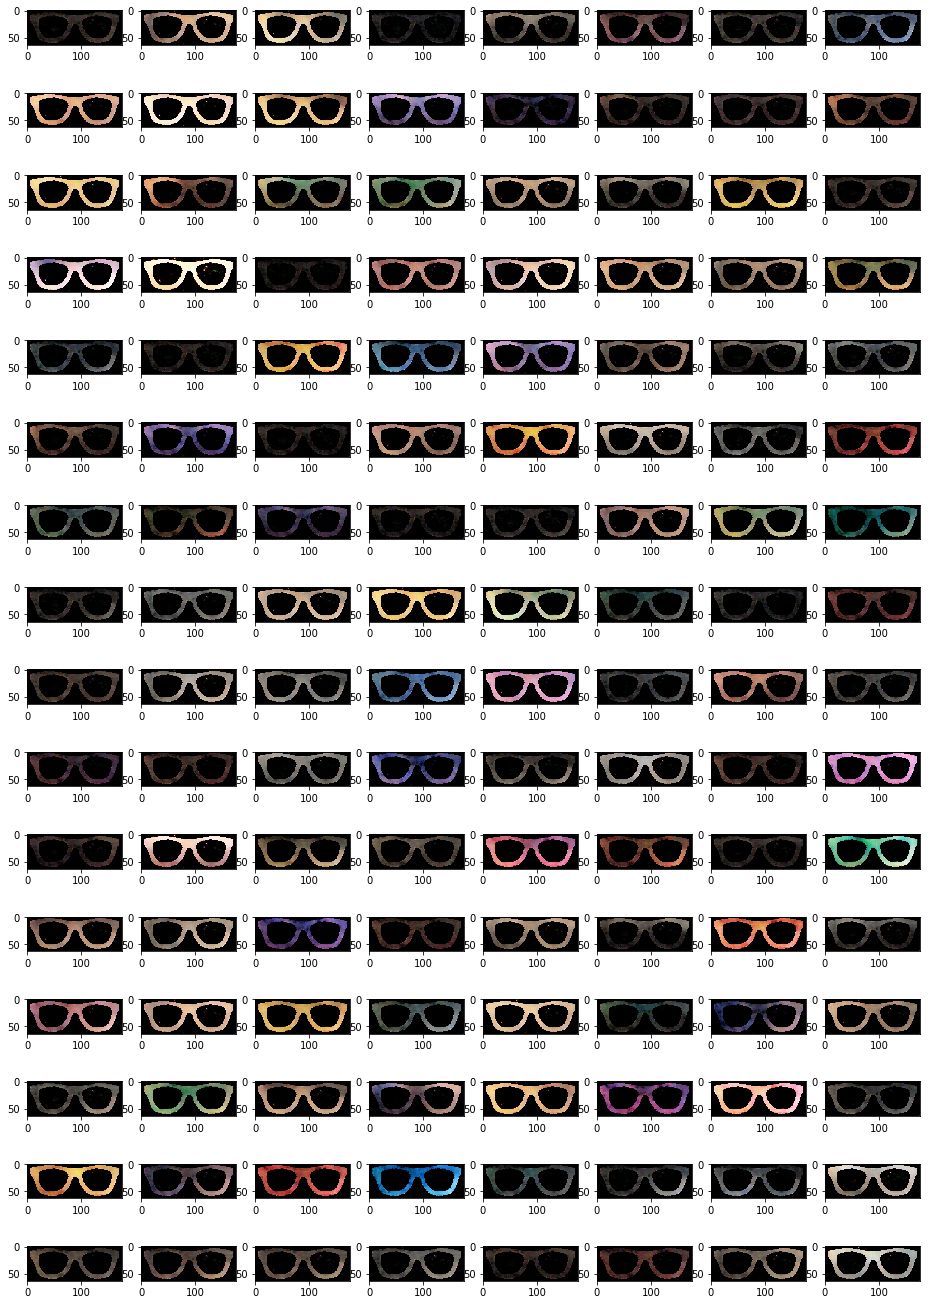

In [100]:
plt.figure(figsize=[16, 24])
sample_images(16, 8, generator)

# Note: a no-nonsense neural network should be able to produce reasonably good images after 15k iterations
# By "reasonably good" we mean "resembling a car crash victim" or better